In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
plt.rc("font", family="serif", size=16)
plt.rc("axes", titlesize="medium")
plt.rc("text.latex", preamble=r"\usepackage{amsmath}")
plt.rc("text", usetex=True)

# This is a notebook example on the preprocessing improvements made to the jet multiplicity $N$ and the groomed momentum fraction $z_{g}$

## The jet multiplicity $N$

Let's start with a simple tensor of integer numbers.

Text(0, 0.5, 'Normalized')

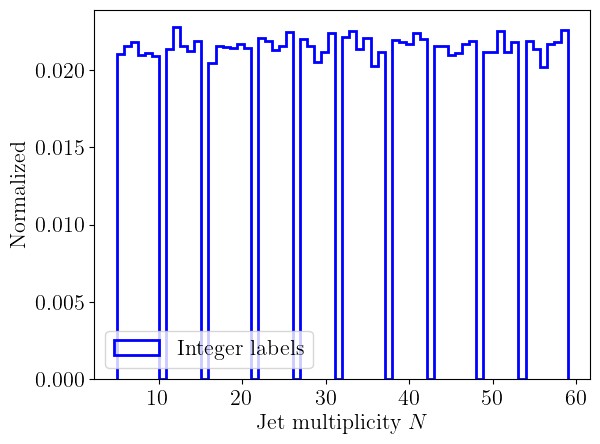

In [2]:
SAMPLE_SIZE = 100000
xlabel = r"Jet multiplicity $N$"
ylabel = r"Normalized"

# Initial tensor x that is composed of six observables
x = torch.rand(SAMPLE_SIZE, 6)

# with the jet multiplicity being an integer number
x[:, 2] = torch.randint(low=5, high=60, size=(SAMPLE_SIZE,), dtype=torch.long)
h, bins = np.histogram(x[:, 2], bins=64)

# as we can see this gives empty phase space regions between integers, which is not ideal for a network to learn
fig, ax = plt.subplots()
ax.hist(x[:,2], bins = bins, density = True, histtype="step", lw =2, ls = "solid", label = "Integer labels", color = "blue")
ax.legend(loc="best")
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)

This can be easily cured with some dedicated preprocessing. We can use the `torch.rand_like()` function, which draws samples from a uniform distribution in $[0,\ 1)$, to smooth out the integer labels. In our case, the uniform noise is added $[-0.5,\ 0.5)$, so that the transformation is invertible by simply rounding back again to the nearest  integer.

Text(0, 0.5, 'Normalized')

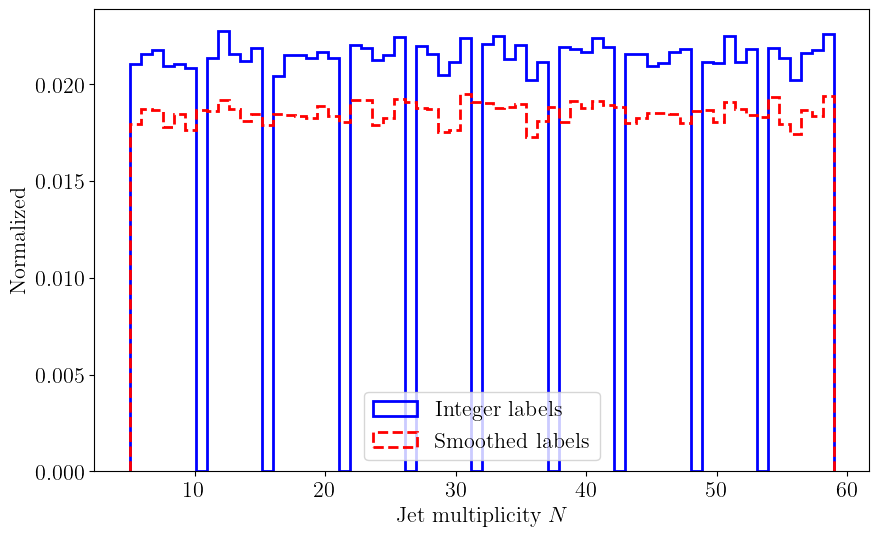

In [3]:
uniform_noise = torch.rand_like(x[:, 2]) - 0.5
x_smoothed = x.clone()
x_smoothed[:, 2] = x[:, 2] + uniform_noise

# Now the empty bins of the distribution have been filled and diffusion networks have a much easier time learning it
fig, ax = plt.subplots(figsize=(10,6))
ax.hist(x[:,2], bins = bins, density = True, histtype="step", lw =2, ls = "solid", label = "Integer labels", color = "blue")
ax.hist(x_smoothed[:,2], bins = bins, density = True, histtype="step", lw =2, ls = "dashed", label = "Smoothed labels", color = "red")
ax.legend(loc="best")
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)

We can also check that this transformation is invertible by rounding the smoothed labels to the nearest integer and plotting the differences with the integer labels

All integer labels recovered: True


Text(0, 0.5, 'Normalized')

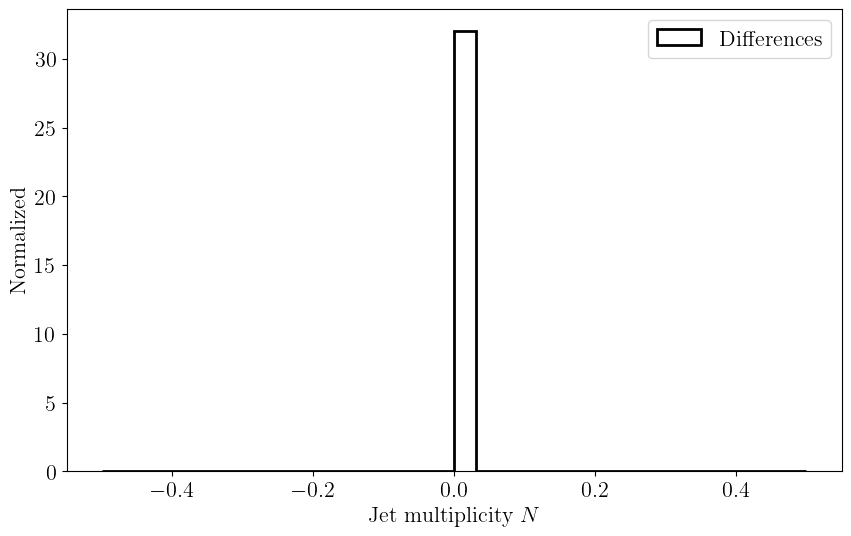

In [4]:
print("All integer labels recovered:", torch.all((x[:,2] - torch.round(x_smoothed[:,2])) == 0).item())

fig, ax = plt.subplots(figsize=(10,6))
ax.hist(x[:,2] - torch.round(x_smoothed[:,2]), bins = 32, density = True, histtype="step", lw =2, ls = "solid", label = "Differences", color = "black")
ax.legend(loc="best")
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)

## Groomed momentum fraction $z_{g}$

Let's first obtain a tensor that looks reasonably similar to the one found in the dataset. We need 

In [5]:
start_point = 0.1
end_point = 1.5
mask_percentage = 0.05  # 5% of events to be masked to 0
mask = (torch.rand(SAMPLE_SIZE, 1) < mask_percentage).float()

exp_distribution = torch.distributions.exponential.Exponential(0.00001)
exponential_tensor = exp_distribution.sample((SAMPLE_SIZE, 1))

# rescale and map to (0.1, 1.5)
exponential_tensor = start_point + (end_point - start_point) * exponential_tensor / exponential_tensor.max() 
# set some to 0
exponential_tensor *= (1 - mask)

# set a hard upper value at 0.5, although this is not very relevant
exponential_tensor = exponential_tensor[exponential_tensor < 0.5]

Text(0, 0.5, 'Normalized')

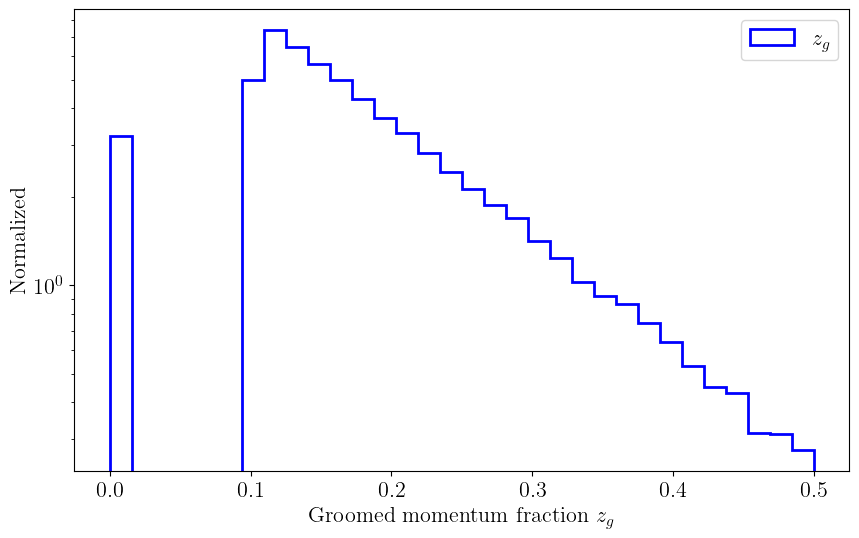

In [6]:
# check shape
xlabel = r"Groomed momentum fraction $z_{g}$"
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(exponential_tensor, bins = 32, density = True, histtype="step", lw =2, ls = "solid", label = r"$z_{g}$", color = "blue")
ax.legend(loc="best")
ax.set_yscale("log")
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)

The preprocessing on the groomed momentum fraction is a bit more complex but also quite easy to implement. The idea is to remap the underflow bin closer to the rest of the distribution and then making it as similar as possible to a gaussian, all while keeping every transformation invertible. We start with a tensor x4 ( = x[:, 4] i.e. the groomed momentum fraction $z_{g}$) and:
1. Add uniform noise in $[0.097, 0.1)$ to the points where x4 is 0.
2. Take the $\log$.
3. Shift the distribution by the midpoint and scale it with the absolute maximum value.
4. Take the inverse error function, which maps a uniform distribution in $(-1, 1)$ to a standard gaussian.

In [7]:
x4 = exponential_tensor
x4_smoothed = x4.clone()

# 1. Add uniform noise in [0.097, 0.1) to the points where x4 is 0.
noise = torch.rand(size=x4_smoothed.shape)*0.003 + 0.097
x4_smoothed = torch.where(x4_smoothed < 0.1, noise, x4_smoothed)

# 2. Take the log
x4_smoothed = x4_smoothed.log()

# 3. Shift the distribution by the midpoint and scale it with the absolute maximum value
shift = (x4_smoothed.max() + x4_smoothed.min())/2.
x4_smoothed -= shift
factor = max(x4_smoothed.max(), -1 * x4_smoothed.min())*1.001 # the 1.001 factor makes sure (-1, 1) is an open interval
x4_smoothed /= factor

# 4. Take the inverse error function, which maps a uniform distribution in (-1, 1) to a standard gaussian.
x4_smoothed = torch.erfinv(x4_smoothed)

Text(0, 0.5, 'Normalized')

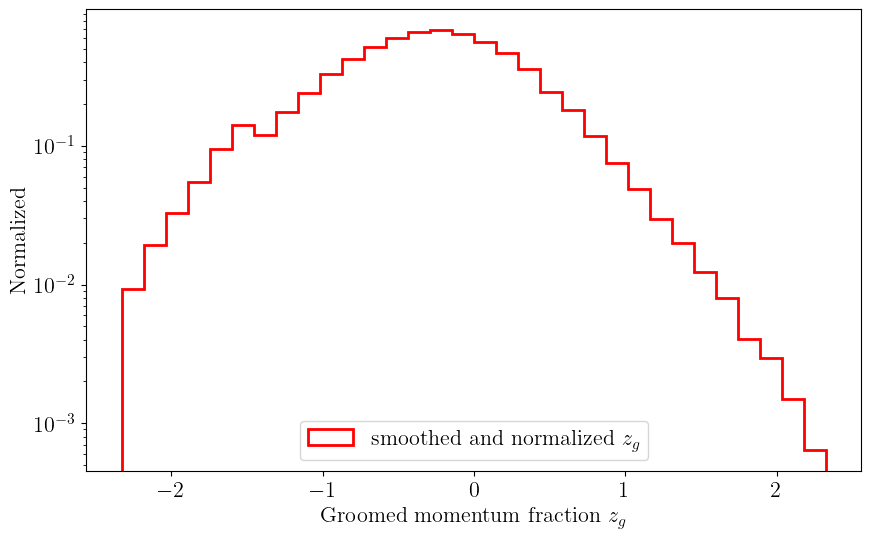

In [8]:
# check shape
fig, ax = plt.subplots(figsize=(10,6))
ax.hist(x4_smoothed, bins = 32, density = True, histtype="step", lw =2, ls = "solid", label = r"smoothed and normalized $z_{g}$", color = "red")
ax.legend(loc="best")
ax.set_yscale("log")
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)

Let's do the same as for the momentum fraction and check that we recover the initial values

All values recovered: True


Text(0, 0.5, 'Normalized')

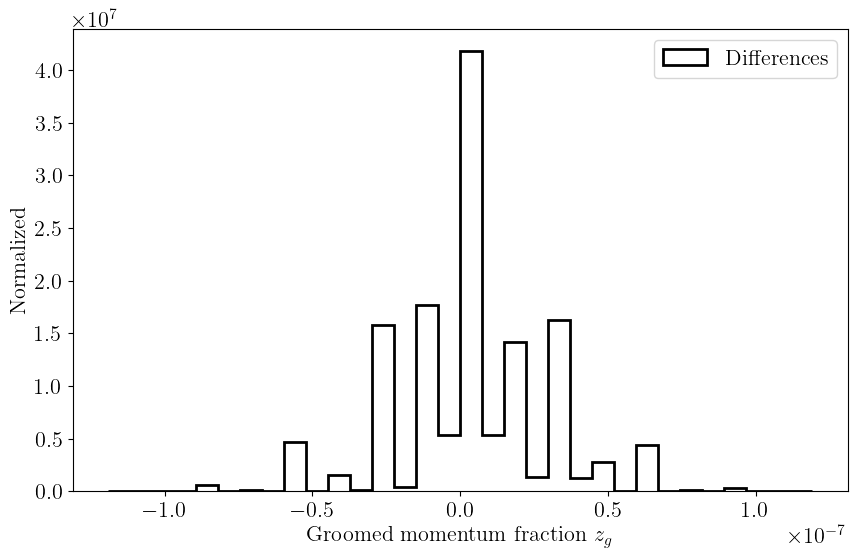

In [9]:
x4_unsmoothed = x4_smoothed.clone()

# 4. Take the error function
x4_unsmoothed = torch.erf(x4_unsmoothed)

# 3. Shift the distribution by the midpoint and scale it with the absolute maximum value
x4_unsmoothed *= factor
x4_unsmoothed += shift

# 2. Take the exp
x4_unsmoothed = x4_unsmoothed.exp()

# 1. Remap whatever there is between 0 and 0.1 to 0. This works because the all the values that were below 0.1 were actually ALL 0
x4_unsmoothed = torch.where(x4_unsmoothed < 0.1, 0, x4_unsmoothed)


print("All values recovered:", (torch.all(x4_unsmoothed - x4) == 0).item())

fig, ax = plt.subplots(figsize=(10,6))
ax.hist(x4_unsmoothed - x4, bins = 32, density = True, histtype="step", lw =2, ls = "solid", label = "Differences", color = "black")
ax.legend(loc="best")
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)

This gives some non-zero differences but they are originated from limited bit precision and are of the order of $10^{-7}$, so we can just ignore them or round them down to 0.

## Actual implementation 

Here we show the actual code snippet that implements these transformations in our code


### Jet multiplicity
```
class UniformNoisePreprocessing(PreprocTrafo):
    def __init__(self, shape: Tuple[int, ...], channels):

        super().__init__(input_shape=shape, output_shape=shape, invertible=True)
        self.channels = channels

    def transform(self, x: torch.Tensor, rev: bool) -> torch.Tensor:
        if rev:
            z = x.clone()
            z[:, self.channels] = torch.round(z[:, self.channels])
        else:
            z = x.clone()
            noise = torch.rand_like(z[:, self.channels])-0.5
            z[:, self.channels] = z[:, self.channels] + noise
        return z
```



### Groomed momentum fraction
```
class SpecialPreproc(PreprocTrafo):
    def __init__(
        self,
        shape: Tuple[int, ...]
    ):
        super().__init__(input_shape=shape, output_shape=shape, invertible=True)

    def transform(self, x: torch.Tensor, rev: bool) -> torch.Tensor:
        if rev:
            z = x.clone()
            z4 = z[:, 4]
            z4 = torch.erf(z4)
            z4 = z4*self.factor
            z4 = z4+self.shift
            z4 = z4.exp()
            z4 = torch.where(z4 < 0.1, 0, z4)
            z[:, 4] = z4
        else:
            z = x.clone()
            z4 = z[:, 4]
            noise = torch.rand(size=z4.shape, device=x.device)/1000. * 3 + 0.097
            z4 = torch.where(z4 < 0.1, noise, z4)
            z4 = z4.log()
            self.shift = (z4.max() + z4.min())/2.
            z4 = z4-self.shift
            self.factor = max(z4.max(), -1 * z4.min())*1.001
            z4 = z4/self.factor
            z4 = torch.erfinv(z4)
            z[:, 4] = z4
        return z
```